Note: The CSV file provided comprises of a dataset which also consists data points in the ocean. First, we will augment the dataset in a way that ocean points no longer exist. This is to ensure efficiency in the real world applications when implemented.

In [ ]:
!pip install geopandas shapely

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving cleaned_geospatial_data.csv to cleaned_geospatial_data.csv


The provided dataset

In [ ]:
df = pd.read_csv('cleaned_geospatial_data.csv')
df

,longitude,latitude
0,36.861544,-5.177747
1,51.463766,5.392935
2,51.190492,4.453765
3,51.326247,6.085953
4,54.529777,9.029133
...,...,...
5925,50.003216,9.717080
5926,47.771913,1.642025
5927,51.973487,4.133423
5928,50.207400,7.336791


using naturalearth physical data to position our original CSV dataset, without the ocean points

In [ ]:
!wget -O ne_110m_land.zip https://naciscdn.org/naturalearth/110m/physical/ne_110m_land.zip


--2025-03-26 07:11:33--  https://naciscdn.org/naturalearth/110m/physical/ne_110m_land.zip
Resolving naciscdn.org (naciscdn.org)... 108.156.201.52, 108.156.201.55, 108.156.201.105, ...
Connecting to naciscdn.org (naciscdn.org)|108.156.201.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69700 (68K) [application/zip]
Saving to: ‘ne_110m_land.zip’

ne_110m_land.zip    100%[===================>]  68.07K  --.-KB/s    in 0.02s   

2025-03-26 07:11:33 (3.06 MB/s) - ‘ne_110m_land.zip’ saved [69700/69700]



In [ ]:
!unzip -q ne_110m_land.zip -d land_shapefile


In [ ]:
!ls land_shapefile

ne_110m_land.cpg  ne_110m_land.prj	    ne_110m_land.shp  ne_110m_land.VERSION.txt
ne_110m_land.dbf  ne_110m_land.README.html  ne_110m_land.shx


Plotting the map present on the natural earth data (default world map)

<Axes: >

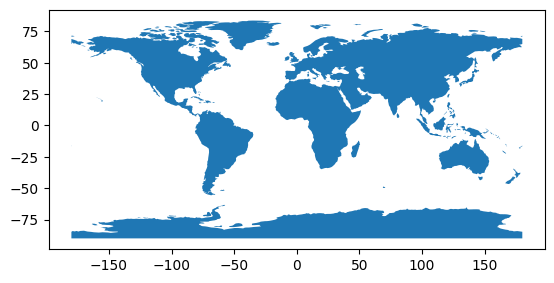

In [ ]:
import geopandas as gpd

land = gpd.read_file("land_shapefile/ne_110m_land.shp")
land.plot()


In [ ]:
df.head()

,longitude,latitude
0,36.861544,-5.177747
1,51.463766,5.392935
2,51.190492,4.453765
3,51.326247,6.085953
4,54.529777,9.029133


In [ ]:
import geopandas as gpd
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]

geo_df = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")


In [ ]:
import geopandas as gpd
land = gpd.read_file("land_shapefile/ne_110m_land.shp")
land.head()


,featurecla,scalerank,min_zoom,geometry
0,Land,1,1.0,"POLYGON ((-59.57209 -80.04018, -59.86585 -80.5..."
1,Land,1,1.0,"POLYGON ((-159.20818 -79.49706, -161.1276 -79...."
2,Land,1,0.0,"POLYGON ((-45.15476 -78.04707, -43.92083 -78.4..."
3,Land,1,1.0,"POLYGON ((-121.21151 -73.50099, -119.91885 -73..."
4,Land,1,1.0,"POLYGON ((-125.55957 -73.48135, -124.03188 -73..."


In [ ]:
df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

In [ ]:

gdf_land = gdf[gdf.geometry.within(land.unary_union)]


gdf_land.drop(columns=['geometry']).to_csv("cleaned_geospatial_data_no_ocean.csv", index=False)

print("Ocean points removed! Saved as cleaned_geospatial_data_no_ocean.csv")


<ipython-input-27-de8a8f53f8bd>:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_land = gdf[gdf.geometry.within(land.unary_union)]


Ocean points removed! Saved as cleaned_geospatial_data_no_ocean.csv


In [ ]:
import folium

# initializing the map at the center (mean) of the cleaned dataset
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=4)

# plotting cleaned points
for _, row in gdf_land.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2, color="blue", fill=True, fill_color="blue"
    ).add_to(m)

m


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import folium
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [ ]:
X = df[['longitude', 'latitude']]

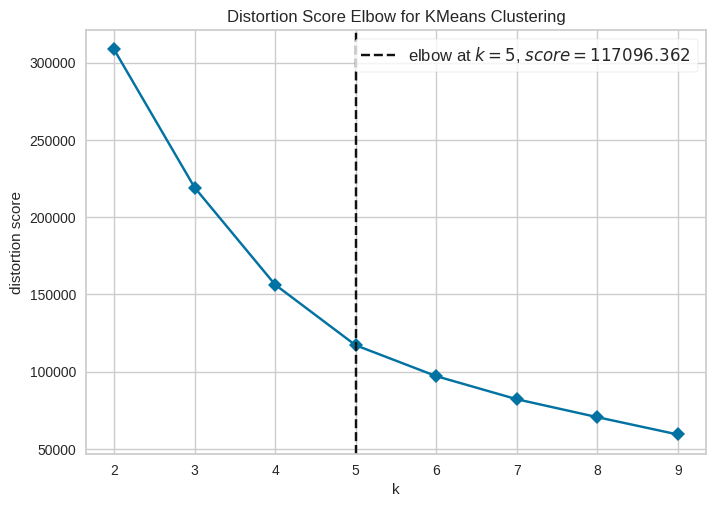

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model, k=(2, 10), metric='distortion', timings=False)
visualizer.fit(X)
visualizer.show()

In [ ]:
optimal_clusters = visualizer.elbow_value_
print(f"Optimal Clusters: {optimal_clusters}")

Optimal Clusters: 5


In [ ]:
kmeans = KMeans(n_clusters=optimal_clusters, n_init=10, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

In [ ]:
import pandas as pd
df = pd.read_csv("/content/cleaned_geospatial_data_no_ocean.csv")

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
X = df[['latitude', 'longitude']].values
k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X)

In [ ]:
import geopandas as gpd
import pandas as pd

df = pd.read_csv('cleaned_geospatial_data.csv')
land = gpd.read_file("land_shapefile/ne_110m_land.shp")
gdf_land = gdf[gdf.geometry.within(land.unary_union)]
gdf_land.drop(columns=['geometry']).to_csv("cleaned_geospatial_data_no_ocean.csv", index=False)

print("✅ Ocean points removed! Saved as cleaned_geospatial_data_no_ocean.csv")


<ipython-input-58-bddc1a47a09e>:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf_land = gdf[gdf.geometry.within(land.unary_union)]


✅ Ocean points removed! Saved as cleaned_geospatial_data_no_ocean.csv


In [ ]:
from google.colab import files
files.download("cleaned_geospatial_data_no_ocean.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>